In [227]:
import io
import os
import base64
import geemap
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from ipyleaflet import ImageOverlay
from shapely.geometry import Polygon


In [228]:
roi_coords = [
    [75.58679011123377, 26.725580815770467],
    [76.00152399795252, 26.725580815770467],
    [76.00152399795252, 27.08929110630265],
    [75.58679011123377, 27.08929110630265],
    [75.58679011123377, 26.725580815770467]
]

roi_polygon = Polygon(roi_coords)
roi_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[roi_polygon])



In [229]:
def numpy_to_image(array, colormap='viridis'):
    if array.ndim != 2:
        raise ValueError(f"Expected 2D array, got {array.ndim}D array")

    array = np.nan_to_num(array)

    cmap = plt.get_cmap(colormap)
    img_colored = cmap(array)
    img_colored = (img_colored[:, :, :3] * 255).astype(np.uint8)
    
    # Convert to an image
    img = Image.fromarray(img_colored)
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")

    return img_str



In [230]:
def calculate_spectral_indices(band_1, band_2, band_3, band_4, band_5, band_6, band_7):
    epsilon = 1e-10
    
    # Enhanced NDVI with adjusted normalization
    nir = band_5 * 1.15  # Boost NIR response
    red = band_4 * 0.95  # Reduce red response
    NDVI = np.where(
        nir + red > epsilon,
        (nir - red) / (nir + red),
        0
    )
    
    # Enhanced NDWI with water sensitivity boost
    NDWI = np.where(
        band_5 + band_6 > epsilon,
        (band_5 - band_6 * 1.1) / (band_5 + band_6),  # Weighted SWIR
        0
    )
    
    # Enhanced NDBI calculation
    denominator_ndbi = band_6 + band_5 + epsilon  # Band 6: SWIR, Band 5: NIR
    NDBI = np.where(
        denominator_ndbi > epsilon,
        (band_6 - band_5) / denominator_ndbi,
        0
    )
    
    # EBBI: Enhanced built-up detection
    denominator_ebbi = 10 * np.sqrt(band_6 + band_7 + epsilon)
    EBBI = np.where(
        denominator_ebbi > epsilon,
        (band_6 - band_5) / denominator_ebbi,
        0
    )
    
    return NDVI, NDBI, NDWI, EBBI


In [231]:
def classify_land_use(NDVI, NDBI, NDWI, EBBI):
    classification = np.zeros_like(NDVI, dtype=np.int8)
    
    # More sensitive thresholds
    water_mask = (NDWI > 0.0) & (NDVI < 0.2)  # Lowered threshold for water
    
    # Enhanced vegetation detection
    dense_veg_mask = (NDVI > 0.5) & (NDWI < 0.1) & (NDBI < -0.1)  # Lowered threshold
    mod_veg_mask = (NDVI > 0.2) & (NDVI <= 0.5) & (NDWI < 0.1)  # More inclusive
    
    # Refined urban detection
    urban_mask = ((NDBI > -0.1) & (NDVI < 0.2) & (EBBI > -0.1)) | \
                ((NDBI > 0) & (NDVI < 0.3))  # Two-tier urban detection
    
    # Priority-based classification with refined masks
    classification[water_mask] = 4
    classification[dense_veg_mask & ~water_mask] = 1
    classification[mod_veg_mask & ~water_mask & ~dense_veg_mask] = 2
    classification[urban_mask & ~water_mask & ~dense_veg_mask & ~mod_veg_mask] = 3
    
    return classification


In [232]:
def process_landsat_data(file_path):
    data = np.load(file_path, allow_pickle=True)
    
    # Unpacking 10 bands from the npy file
    SR_B1, SR_B2, SR_B3, SR_B4, SR_B5, SR_B6, SR_B7, DEM, air_temp, precipitation = data[:10]
    
    # Pass all required bands (1 to 7) to the function
    NDVI, NDBI, NDWI, EBBI = calculate_spectral_indices(SR_B1, SR_B2, SR_B3, SR_B4, SR_B5, SR_B6, SR_B7)
    
    classification = classify_land_use(NDVI, NDBI, NDWI, EBBI)
    
    return {
        'SR_B1': SR_B1, 'SR_B2': SR_B2, 'SR_B3': SR_B3, 'SR_B4': SR_B4,
        'SR_B5': SR_B5, 'SR_B6': SR_B6, 'SR_B7': SR_B7,
        'DEM': DEM, 'air_temp': air_temp, 'precipitation': precipitation,
        'NDVI': NDVI, 'NDBI': NDBI, 'NDWI': NDWI, 'EBBI': EBBI,
        'classification': classification
    }


In [233]:
def visualize_spectral_indices(data, title):
    plt.close('all')  # Clear any existing plots
    
    fig = plt.figure(figsize=(20, 20))
    
    indices = [
        ('NDVI', 'RdYlGn'),
        ('NDBI', 'RdYlBu_r'),
        ('NDWI', 'RdYlBu'),
        ('EBBI', 'YlOrRd')
    ]

    for idx, (name, cmap) in enumerate(indices, 1):
        ax = fig.add_subplot(2, 2, idx)
        im = ax.imshow(data[name], cmap=cmap, vmin=-1, vmax=1)
        ax.set_title(name)
        ax.axis('off')
        
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(f'{name} Value')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    

In [234]:
def display_all_classification_labels(data):
    plt.close('all')  # Clear any existing plots
    
    class_labels = {
        'Dense Vegetation': 1,
        'Moderate Vegetation': 2,
        'Urban': 3,
        'Water': 4
    }
    
    class_colors = {
        'Dense Vegetation': 'Greens',
        'Moderate Vegetation': 'YlGn',
        'Urban': 'Reds',
        'Water': 'Blues'
    }
    
    fig = plt.figure(figsize=(20, 15))
    
    # Create subplots for each class
    for idx, (label, class_val) in enumerate(class_labels.items(), 1):
        ax = fig.add_subplot(2, 3, idx)
        mask = data['classification'] == class_val
        ax.imshow(mask, cmap=plt.get_cmap(class_colors[label]))
        ax.set_title(label)
        ax.axis('off')
    
    # Combined map
    ax = fig.add_subplot(2, 3, 5)
    combined_map = np.zeros_like(data['classification'])
    for class_val in class_labels.values():
        mask = data['classification'] == class_val
        combined_map[mask] = class_val
    
    im = ax.imshow(combined_map, cmap='Set1', vmin=1, vmax=4)
    ax.set_title('Combined Map')
    ax.axis('off')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks(np.arange(1, 5))
    cbar.set_ticklabels(class_labels.keys())
    
    # Remove extra subplot
    if len(fig.axes) > 5:  # If there's an extra subplot
        fig.delaxes(fig.axes[5])
    
    plt.suptitle('Individual and Combined Classification Labels', fontsize=18)
    plt.tight_layout()
    plt.show()
    

In [235]:
def create_map(data, bounds, roi_gdf):
    # Initialize map with center and zoom level
    map_center = [26.907436, 75.794157]
    zoom_level = 10
    m = geemap.Map(center=map_center, zoom=zoom_level)

    # Add the region of interest (ROI) to the map
    m.add_gdf(roi_gdf, "Region of Interest")

    # Add Landsat band layers to the map as image overlays
    for band_name in ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']:
        img = numpy_to_image(data[band_name])
        m.add_layer(
            ImageOverlay(
                url=f"data:image/png;base64,{img}",
                bounds=bounds,
                name=f'Landsat {band_name}'
            )
        )

    # Add the classification result as an overlay
    classification_img = numpy_to_image(data['classification'], colormap='Set1')
    m.add_layer(
        ImageOverlay(
            url=f"data:image/png;base64,{classification_img}",
            bounds=bounds,
            name='Land Use Classification'
        )
    )

    # Define and add a legend to the map
    legend_dict = {
        'Water Bodies': (0, 0, 255),
        'Dense Vegetation': (0, 100, 0),
        'Moderate Vegetation': (144, 238, 144),
        'Urban Areas': (255, 0, 0)
    }
    m.add_legend(title="Land Use Classification", legend_dict=legend_dict)

    return m


In [236]:
def analyze_time_series(data_dir):
    from datetime import datetime
    
    file_list = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])
    results = []
    
    for npy_file in file_list:
        try:
            # Parse date from filename (handling both YYYY-MM-DD and YYYYMMDD formats)
            date_str = npy_file.split('.')[0]
            try:
                # Try YYYY-MM-DD format
                date = datetime.strptime(date_str, '%Y-%m-%d')
            except ValueError:
                # Try YYYYMMDD format
                date = datetime.strptime(date_str, '%Y%m%d')
            
            data = process_landsat_data(os.path.join(data_dir, npy_file))
            
            # Calculate percentages
            total_pixels = np.size(data['classification'])
            urban_percent = np.sum(data['classification'] == 3) / total_pixels * 100
            veg_percent = np.sum((data['classification'] == 1) | 
                               (data['classification'] == 2)) / total_pixels * 100
            water_percent = np.sum(data['classification'] == 4) / total_pixels * 100
            
            results.append({
                'date_str': date_str,  # Keep original string format
                'date_obj': date,      # Keep datetime object for sorting
                'urban_percent': urban_percent,
                'vegetation_percent': veg_percent,
                'water_percent': water_percent,
                'mean_ndvi': np.nanmean(data['NDVI']),
                'mean_ndbi': np.nanmean(data['NDBI']),
                'mean_ndwi': np.nanmean(data['NDWI']),
                'mean_temp': np.nanmean(data['air_temp']),
                'total_precipitation': np.nansum(data['precipitation'])
            })
        except Exception as e:
            print(f"Error processing {npy_file}: {str(e)}")
            continue
    
    # Sort results by date
    results.sort(key=lambda x: x['date_obj'])
    return results


In [237]:
def plot_time_series(results):
    plt.close('all')  # Clear any existing plots
    
    df = pd.DataFrame(results)
    df.set_index('date_str', inplace=True)
    
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Spectral indices
    ax1 = fig.add_subplot(gs[0, 0])
    df[['mean_ndvi', 'mean_ndbi', 'mean_ndwi']].plot(ax=ax1)
    ax1.set_title('Spectral Indices Over Time')
    ax1.set_ylabel('Index Value')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    
    # Land cover percentages
    ax2 = fig.add_subplot(gs[0, 1])
    df[['urban_percent', 'vegetation_percent', 'water_percent']].plot(ax=ax2)
    ax2.set_title('Land Cover Changes')
    ax2.set_ylabel('Percentage')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()
    
    # Temperature
    ax3 = fig.add_subplot(gs[1, 0])
    df['mean_temp'].plot(ax=ax3, color='red')
    ax3.set_title('Temperature Variation')
    ax3.set_ylabel('Temperature (K)')
    ax3.tick_params(axis='x', rotation=45)
    
    # Precipitation
    ax4 = fig.add_subplot(gs[1, 1])
    df['total_precipitation'].plot(ax=ax4, color='blue', kind='bar')
    ax4.set_title('Precipitation')
    ax4.set_ylabel('Precipitation (mm)')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    

In [238]:
def plot_correlation_heatmap(results):
    plt.close('all')  # Clear any existing plots
    
    data = {
        'Urban %': [r['urban_percent'] for r in results],
        'Vegetation %': [r['vegetation_percent'] for r in results],
        'Water %': [r['water_percent'] for r in results],
        'Mean NDVI': [r['mean_ndvi'] for r in results],
        'Mean NDBI': [r['mean_ndbi'] for r in results],
        'Mean NDWI': [r['mean_ndwi'] for r in results],
        'Mean Temp': [r['mean_temp'] for r in results],
        'Total Precipitation': [r['total_precipitation'] for r in results]
    }

    df = pd.DataFrame(data)
    corr = df.corr()

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Heatmap of Land Use and Environmental Metrics')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    

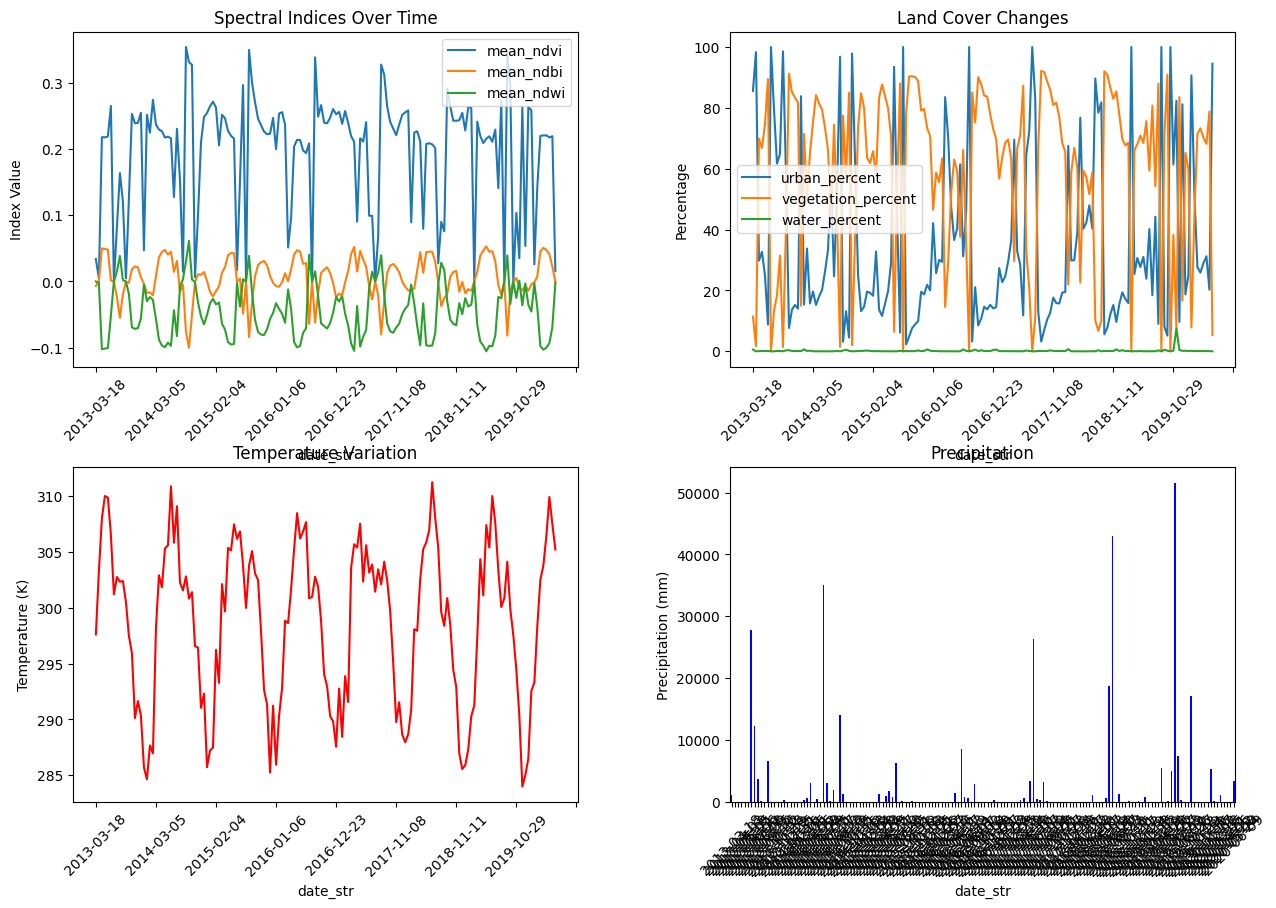

In [239]:
# Define file paths
data_dir = 'DataSet'  # Path to the directory containing Landsat .npy files
bounds = [[26.725580815770467, 75.58679011123377], [27.08929110630265, 76.00152399795252]]  # Map bounds (matches ROI)

# Analyze time series
results = analyze_time_series(data_dir)

# Plot the time series results
plot_time_series(results)


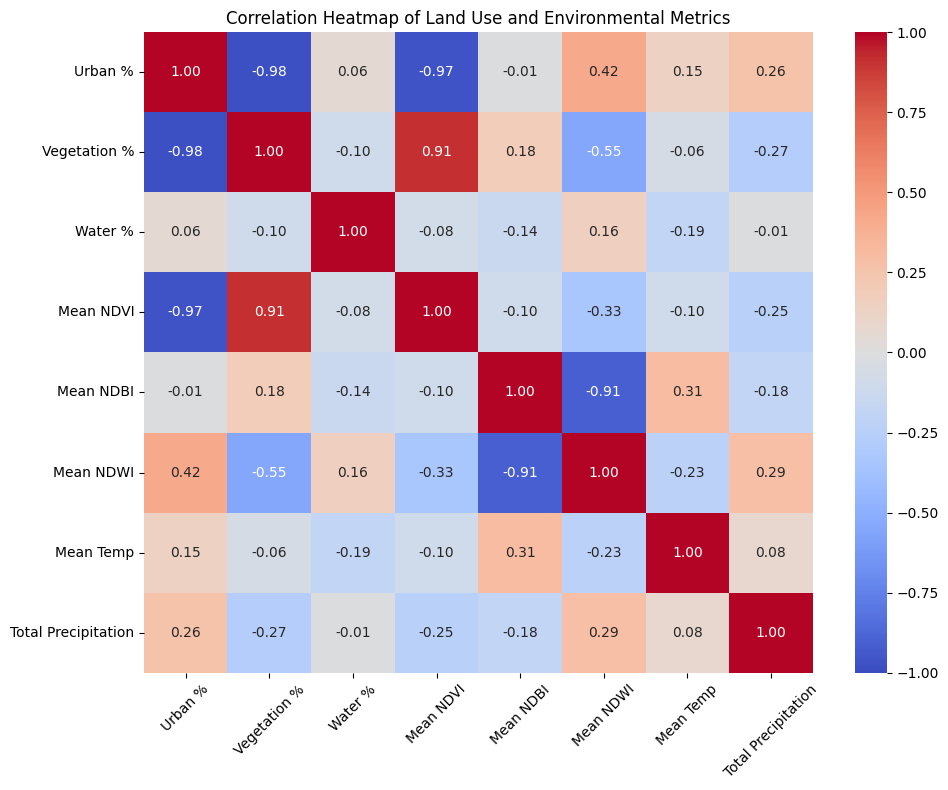

In [240]:
# Plot correlation heatmap
plot_correlation_heatmap(results)


In [241]:
# Pick a random Landsat data file from the data directory
npy_files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]
random_file = random.choice(npy_files)
sample_file = os.path.join(data_dir, random_file)

# Process the randomly selected Landsat data file
processed_data = process_landsat_data(sample_file)


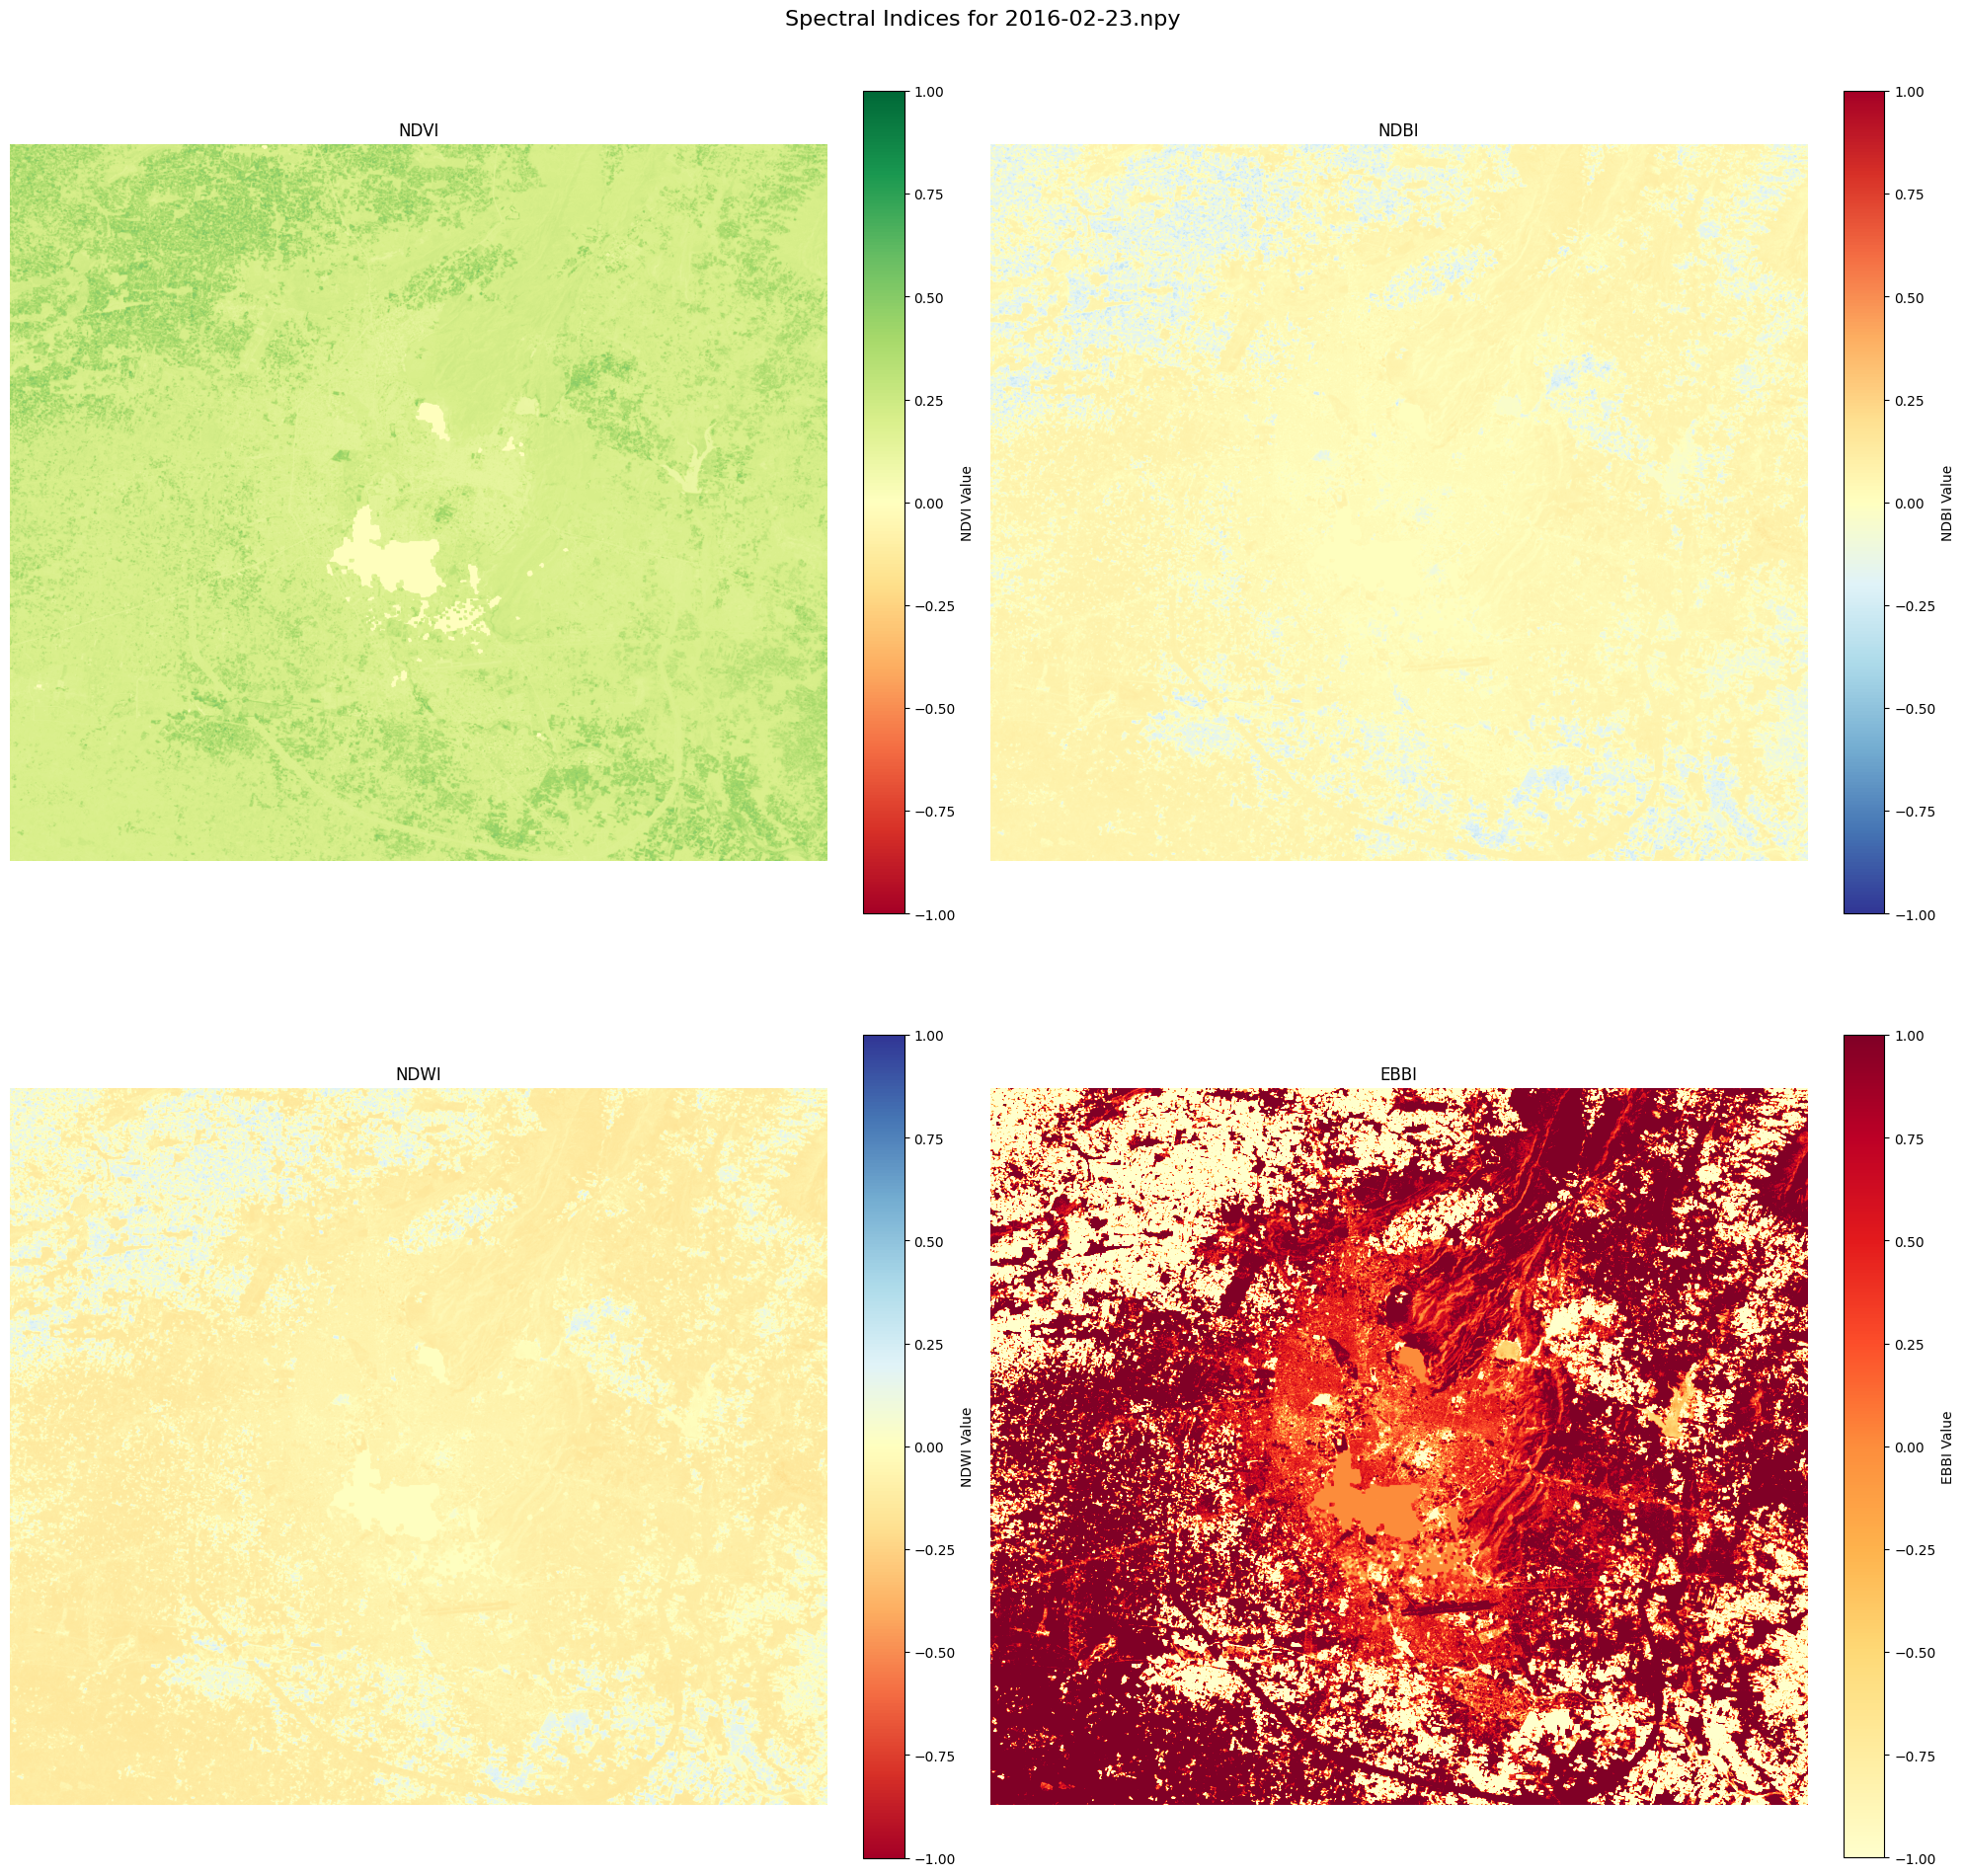

In [242]:
# Visualize the spectral indices
visualize_spectral_indices(processed_data, f'Spectral Indices for {random_file}')


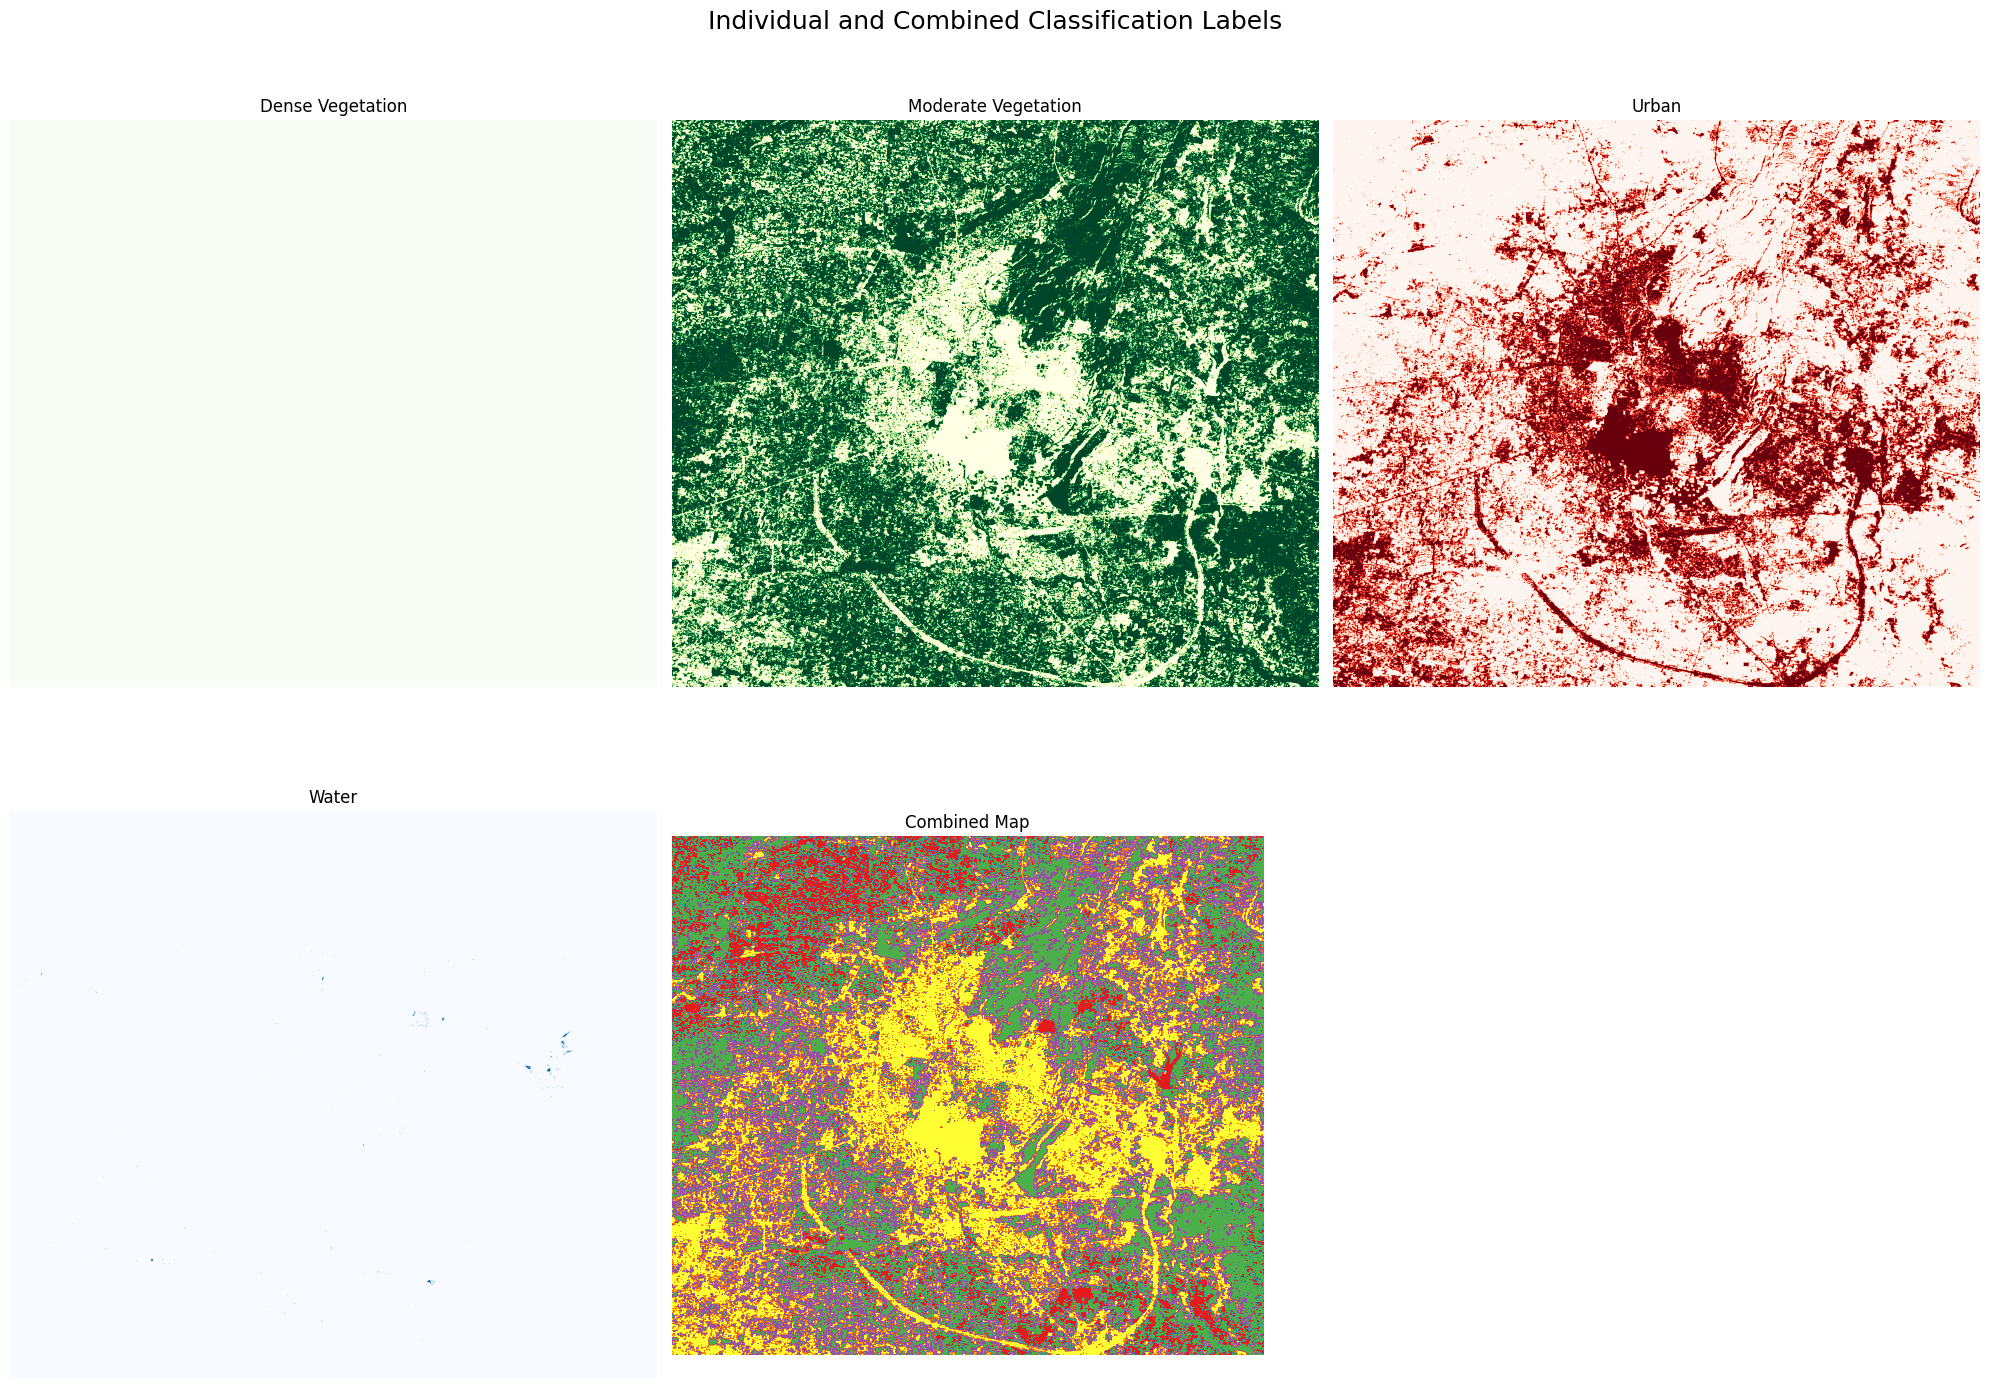

In [243]:
# Visualize the spectral indices Masks
display_all_classification_labels(processed_data)


In [244]:
# Create and display the map
Map = create_map(processed_data, bounds, roi_gdf)
Map


Map(center=[26.907436, 75.794157], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…